In [864]:
import cv2
import pandas as pd
import numpy as np
import os
import math
import json

from pdf2image import convert_from_path
from PIL import Image
from matplotlib import pyplot as plt

pd.options.display.max_rows = 500

In [ ]:
#### 최신버전
def convert_pdf_folder_to_images(pdf_folder, output_folder, chk = False):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(pdf_folder):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(pdf_folder, filename)
            images = convert_from_path(pdf_path)
            base_filename = os.path.splitext(filename)[0]
            
            for page_num, img in enumerate(images):
                if page_num == 0:
                    left_num = len(images)*2
                    right_num = 1
                else:
                    left_num = right_num + 1
                    right_num = left_num + 1
                    
                output_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}.jpg")
                img.save(output_path, 'JPEG')
                
                if chk:
                    width, height = img.size
                    print(width, height)
                    # width -= 20
                    # height -= 20
                    # left_half = img.crop((20, 20, width // 2, height))
                    # right_half = img.crop((width // 2, 20, width, height))
                    crop_size = 30
                    left_half = img.crop((crop_size, crop_size, int((width/2)-crop_size), height-crop_size))
                    right_half = img.crop((int((width/2)+crop_size), crop_size, width-crop_size, height-crop_size))
                else:
                    width, height = img.size
                    left_half = img.crop((0, 0, width // 2, height))
                    right_half = img.crop((width // 2, 0, width, height))
                    
                # left_half_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}_left.jpg")
                # right_half_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}_right.jpg")
                left_half_path = os.path.join(output_folder, f"{base_filename}_{left_num}.jpg")
                right_half_path = os.path.join(output_folder, f"{base_filename}_{right_num}.jpg")
                
                left_half.save(left_half_path, 'JPEG')
                right_half.save(right_half_path, 'JPEG')
                
# pdf_folder = './scan/datas/pdf'  # PDF 파일이 있는 폴더 경로
# output_folder = './scan/datas/pdf/divided/t2'  # 출력 이미지 파일을 저장할 폴더 경로
pdf_folder = './scan/datas/pdf/'  # PDF 파일이 있는 폴더 경로
output_folder = './scan/datas/pdf/divided/tem'  # 출력 이미지 파일을 저장할 폴더 경로

convert_pdf_folder_to_images(pdf_folder, output_folder, chk = False) # chk : True -> 마킹된 검사지 

In [ ]:
#### 최신버전
def is_square(cnt, min_area, max_area):
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    
    # 정사각형은 꼭지점이 4개여야 함
    if len(approx) != 4:
        return False

    # 각도와 비율 체크
    for i in range(4):
        pt1 = approx[i][0]
        pt2 = approx[(i + 1) % 4][0]
        pt3 = approx[(i + 2) % 4][0]
        
        vec1 = pt2 - pt1
        vec2 = pt3 - pt2
        
        dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
        magnitude1 = np.sqrt(vec1[0]**2 + vec1[1]**2)
        magnitude2 = np.sqrt(vec2[0]**2 + vec2[1]**2)
        
        cos_angle = dot_product / (magnitude1 * magnitude2)
        angle = np.arccos(cos_angle) * (180 / np.pi)
        
        if angle < 80 or angle > 100:  # 각도가 직각에 가까운지 체크
            return False
    
    # 가로와 세로의 길이가 거의 같은지 확인
    x, y, w, h = cv2.boundingRect(approx)
    if abs(w - h) > min(w, h) * 0.1:  # 정사각형 비율이 아닌 경우 제외
        return False
    
    area = cv2.contourArea(cnt)
    if area < min_area or area > max_area:
        return False

    return True

def draw_contours(image_folder, output_folder, min_area=100, max_area=1000):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cut_img_dict = dict()
    for filename in os.listdir(image_folder):
        if (filename.endswith('.jpg')) and ("_page" not in filename):
            # if "MIT" not in filename:
            #     continue
            # print(filename)
            for_path = filename.replace(".jpg", "")
            splited_for_path = for_path.split("_")
            page_num = splited_for_path[-1]
            pj_name = "_".join(splited_for_path[:-1])
            if pj_name not in cut_img_dict:
                cut_img_dict[pj_name] = []
                
            image_path = os.path.join(image_folder, filename)
            img = cv2.imread(image_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (7, 7), 0)

            # 경계 검출 (Canny Edge Detection)
            edges = cv2.Canny(blurred, 50, 100) # 50 100

            # 윤곽선 검출
            contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # 사각형 및 크기 필터링
            rectangles = [cnt for cnt in contours if is_square(cnt, min_area, max_area)]
            
            # cv2.drawContours(img, rectangles, -1, (0, 0, 255), 5)
            # plt.figure(figsize=(20, 20))
            # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()
            
            rectangles = rectangles[:2] + rectangles[-2:]
            # 원본 이미지에 윤곽선 그리기
            # x 좌표와 y 좌표가 가장 작은 점이 좌상단 (top-left).
            # x 좌표는 크지만 y 좌표가 작은 점이 우상단 (top-right).
            # x 좌표는 작지만 y 좌표가 큰 점이 좌하단 (bottom-left).
            # x 좌표와 y 좌표가 모두 큰 점이 우하단 (bottom-right).
            cut_xy = []
            for rdx, rect in enumerate(rectangles):
                x, y, w, h = cv2.boundingRect(rect)
                if rdx == 0: # 우하단
                    cut_xy += [x + w]
                    cut_xy += [y + h]
                if rdx == 3: # 좌상단
                    cut_xy = [x, y] + cut_xy
                # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 5)
            # cut_img_dict[filename]=cut_xy[:2]
            cut_img_dict[pj_name].append(cut_xy[:2])
            cut_xy = tuple(cut_xy)
            img = img[cut_xy[1]:cut_xy[3], cut_xy[0]:cut_xy[2]]
            # 결과 이미지 저장
            # result_image_path = os.path.join(output_folder, f"square_{filename}")
            result_image_path = os.path.join(output_folder, f"{filename}")
            cv2.imwrite(result_image_path, img)
            # cropped_image.save(result_image_path)
    
    return cut_img_dict

# 사용 예시
image_output_folder = './scan/datas/pdf/divided/tem'
contour_output_folder = './scan/datas/pdf/square/tem'  # 네모를 기준으로 자른 사진을 저장할 폴더 경로

# 이미지에서 윤곽선 검출 및 그리기
cut_img_dict = draw_contours(image_output_folder, contour_output_folder)

In [ ]:
# with open('./scan/datas/json/rects_point_dict.json', 'w') as f:
#     json.dump(rects_point_dict, f, ensure_ascii=False, indent=4)

In [1091]:
#### 최신버전2
rects_point_dict = dict()

In [1092]:
# rects_point_dict['MIT(고등)'] = \
# {1: [[309, 516, 626, 566, [0], 'schl'], [290, 737, 654, 1088, [4, '0.00.00'], ''], [681, 350, 1540, 1093, [3], ''], [549, 1172, 1072, 1240, [5, 4], 'part1'], [1086, 1321, 1494, 1493, [0], 'part1'], [552, 1500, 1234, 1570, [5, 5], 'part1'], [278, 1680, 1507, 1712, [0, 5, 5, 5], 'part1'], [552, 1718, 1338, 1789, [5, 5], 'part1'], [551, 1849, 1355, 1919, [0], 'part1'], [553, 1919, 1314, 1995, [5, 5], 'part1'], [1128, 2074, 1468, 2188, [0, 3, 3, 3], 'part1']], 
#     2: [[602, 171, 777, 2180, [0], 'part2'], [1371, 174, 1542, 2181, [0], 'part2']], 
#     3: [[596, 122, 777, 738, [0], 'part2'], [1365, 126, 1549, 702, [0], 'part2'], [243, 895, 400, 2184, [0], 'part3'], [627, 895, 784, 2180, [0], 'part3'], [1010, 895, 1162, 2184, [0], 'part3'], [1393, 897, 1545, 2190, [0], 'part3']], 
#     4: [[247, 127, 395, 535, [0], 'part3'], [631, 123, 773, 545, [0], 'part3'], [1009, 127, 1157, 538, [0], 'part3'], [1392, 125, 1545, 401, [0], 'part3'], [636, 698, 781, 1549, [0], 'part4'], [1398, 703, 1550, 1482, [0], 'part4'], [263, 1939, 1552, 2102, [0], 'part5']]}


# rects_point_dict['MIT(고등)'] = \
    # {1: [[325, 520, 614, 562, [0], 'gender', ['남']], [293, 735, 664, 1086, [4, '0.00.00'], '', [1]], [682, 347, 1537, 1093, [3], '', [1]], [552, 1173, 1070, 1246, [5, 4], 'part1', [1]], [1091, 1322, 1503, 1498, [0], 'part1', [1]], [551, 1501, 1231, 1567, [5, 5], 'part1', [1]], [271, 1671, 1512, 1714, [0, 5, 5, 5], 'part1', [1, 1, 1]], [553, 1717, 1333, 1784, [5, 5], 'part1', [1]], [552, 1849, 1358, 1920, [0], 'part1', [1]], [555, 1923, 1305, 1996, [5, 5], 'part1', [1]], [1124, 2076, 1472, 2193, [0], 'part1', [1]]], 
    #  2: [[599, 171, 780, 2184, [0], 'part2', [1]], [1371, 174, 1543, 2185, [0], 'part2', [1]]], 
    #  3: [[600, 127, 786, 738, [0], 'part2', [1]], [1368, 130, 1556, 693, [0], 'part2', [1]], [241, 887, 402, 2189, [0], 'part3', [1]], [627, 894, 776, 2177, [0], 'part3', [1]], [1012, 893, 1158, 2183, [0], 'part3', [1]], [1392, 893, 1547, 2181, [0], 'part3', [1]]], 
    #  4: [[247, 122, 398, 545, [0], 'part3', [1]], [628, 125, 780, 545, [0], 'part3', [1]], [1011, 120, 1165, 539, [0], 'part3', [1]], [1391, 122, 1546, 408, [0], 'part3', [1]], [636, 694, 782, 1551, [0], 'part4', [1]], [1402, 700, 1548, 1493, [0], 'part4', [1]], [263, 1936, 1558, 2109, [0], 'part5', [1]]]}
    
    
rects_point_dict['MIT(고등)'] = \
{1: [[315, 507, 629, 580, [0], 'A', ['남'], 'gender', [0, 0]], [288, 733, 659, 1096, [4], 'A', [1, '.', 0, 0, '.', 0, 0], 'sch', [0, 0]], [679, 348, 1543, 1092, [3], 'A', [], 'name', [0, 0]], [547, 1170, 1072, 1243, [5, 4], 'part1', [1], '', [0, 0]], [1091, 1319, 1502, 1500, [0], 'part1', [1], '', [1, 5]], [552, 1498, 1226, 1568, [5, 5], 'part1', [1], '', [0, 0]], [278, 1677, 1504, 1713, [0, 5, 5, 5], 'part1', [1, 1, 1], '', [1, 3]], [552, 1712, 1330, 1785, [5, 5], 'part1', [1], '', [0, 0]], [547, 1847, 1359, 1921, [0, 5, 5], 'part1', [1, 1], '', [0, 0]], [550, 1915, 1315, 1998, [5, 5], 'part1', [1], '', [0, 0]], [1125, 2076, 1463, 2187, [0], 'part1', [1], '', [1, 3]]], 
             2: [[599, 170, 784, 2187, [0], 'part2', [1], '', [0, 0]], [1366, 167, 1549, 2188, [0], 'part2', [1], '', [0, 0]]], 
             3: [[604, 124, 777, 740, [0], 'part2', [1], '', [0, 0]], [1368, 123, 1550, 709, [0], 'part2', [1], '', [0, 0]], [238, 886, 403, 2188, [0], 'part3', [1], '', [0, 0]], [625, 890, 786, 2184, [0], 'part3', [1], '', [0, 0]], [1003, 894, 1163, 2185, [0], 'part3', [1], '', [0, 0]], [1384, 888, 1554, 2191, [0], 'part3', [1], '', [0, 0]]], 
             4: [[242, 121, 398, 544, [0], 'part3', [1], '', [0, 0]], [624, 122, 778, 544, [0], 'part3', [1], '', [0, 0]], [1010, 121, 1162, 545, [0], 'part3', [1], '', [0, 0]], [1384, 116, 1543, 398, [0], 'part3', [1], '', [0, 0]], [623, 693, 786, 1559, [0], 'part4', [1], '', [0, 0]], [1396, 692, 1549, 1490, [0], 'part4', [1], '', [0, 0]], [261, 1933, 1544, 2109, [0], 'part5', [1], '', [1, 3]]]}

In [1093]:
# rects_point_dict['CLS_검사지(중고등)'] = \
# {1: [[271, 427, 632, 601, [0]], [276, 755, 636, 1103, [1]], [667, 365, 1523, 1112, [1]], [580, 1321, 764, 1613, [0]], [1343, 1315, 1531, 1667, [0]], [761, 1740, 1211, 2169, [2, 2, 7, 7, 7]]], 
#  2: [[797, 77, 1281, 748, [2, 5, 6, 5, 4, 6, 6]], [799, 756, 849, 1023, [1, 6]], [612, 1233, 807, 1663, [0]], [1377, 1236, 1559, 1648, [0]], [743, 1804, 801, 2185, [1, 2, 2, 2, 2]], [1507, 1804, 1559, 2183, [1, 2, 2, 2, 2]]], 
#  3: [[696, 123, 771, 501, [1, 2, 2, 2, 2]], [1463, 119, 1543, 408, [1, 2, 2, 2]], [579, 635, 763, 2175, [0]], [1349, 644, 1537, 2183, [0]]], 
#  4: [[619, 123, 796, 2103, [0]], [1383, 128, 1557, 2101, [0]]]}


# rects_point_dict['CLS_검사지(중고등)'] = \
    # {1: [[268, 424, 645, 594, [0], 'schl'], [276, 747, 634, 1111, [4, '0.00.00'], 'pid'], [666, 366, 1531, 1112, [3], 'name'], [587, 1318, 766, 1605, [0], 'part1-1'], [1353, 1323, 1532, 1647, [0], 'part1-2'], [766, 1742, 1211, 2177, [2,2,7,7,7], 'part1-3']], 
    #  2: [[794, 72, 1276, 750, [2, 5, 6, 5, 4, 6, 6], 'part1-3'], [795, 754, 852, 1024, [1], 'part1-3'], [617, 1243, 802, 1659, [0], 'part2-1'], [1384, 1244, 1569, 1658, [0], 'part2-2'], [743, 1815, 799, 2177, [1, 2, 2, 2, 2], 'part3'], [1505, 1814, 1564, 2180, [1, 2, 2, 2, 2], 'part3']], 
    #  3: [[712, 133, 768, 494, [1, 2, 2, 2, 2], 'part3'], [1474, 136, 1532, 402, [1, 2, 2, 2], 'part3'], [590, 648, 762, 2173, [0], 'part4'], [1352, 642, 1528, 2176, [0], 'part4']], 
    #  4: [[611, 132, 802, 2100, [0], 'part4'], [1384, 133, 1571, 2104, [0], 'part4']]}
    
# rects_point_dict['CLS_검사지(중고등)'] = \
#     {1: [[274, 428, 638, 596, [0, 2, 2], 'schl', ['중학교', '남']], [277, 753, 637, 1107, [4, '0.00.00'], '', [1]], [670, 367, 1525, 1106, [3], '', [1]], [590, 1324, 763, 1603, [0], 'part1-1', [1]], [1354, 1323, 1537, 1652, [0, 5, 5, 5, 5, 5, 5, 5], 'part1-2', [1, 1, 1, 1, 1, 1, 1]], [763, 1738, 1205, 2158, [5, 2, 7, 7, 7], 'part1-3', [1, 1, 1, 1]]], 
#     2: [[796, 75, 1288, 750, [5, 5, 6, 5, 4, 6, 6], 'part1-3', [1, 1, 1, 1, 1, 1]], [792, 753, 842, 1033, [1], 'part1-3', [1]], [621, 1244, 793, 1651, [0, 5, 5, 5, 5, 5, 5], 'part2-1', [1, 1, 1, 1, 1, 1]], [1388, 1247, 1563, 1654, [0], 'part2-2', [1]], [748, 1811, 801, 2184, [1, 2, 2, 2, 2], 'part3', [1, 1, 1, 1]], [1513, 1815, 1566, 2189, [1, 2, 2, 2, 2], 'part3', [1, 1, 1, 1]]], 
#     3: [[711, 140, 769, 487, [1, 2, 2, 2, 2], 'part3', [1, 1, 1, 1]], [1478, 132, 1532, 404, [1, 2, 2, 2], 'part3', [1, 1, 1]], [588, 639, 765, 2172, [0], 'part4', [1]], [1348, 646, 1538, 2179, [0], 'part4', [1]]], 
#     4: [[620, 140, 798, 2099, [0], 'part4', [1]], [1387, 137, 1559, 2099, [0], 'part4', [1]]]}



rects_point_dict['CLS_검사지(중고등)'] = \
    {1: [[278, 427, 626, 476, [0], 'A', ['중학교'], 'schtype', [0, 0]], [294, 541, 610, 597, [0], 'A', ['남'], 'gender', [0, 0]], [268, 753, 642, 1112, [4], 'A', [1, '.', 0, 0, '.', 0, 0], 'sch', [0, 0]], [662, 362, 1536, 1117, [3], 'A', [], 'name', [0, 0]], [589, 1319, 763, 1607, [0], 'part1-1', [1], '', [0, 0]], [1354, 1319, 1529, 1652, [0], 'part1-2', [1], '', [0, 0]], [762, 1741, 1206, 2178, [0, 2, 7, 7, 7], 'part1-3', [1, 1, 1, 1], '', [0, 0]]], 
     2: [[793, 71, 1276, 749, [0, 5, 6, 5, 4, 6, 6], 'part1-3', [1, 1, 1, 1, 1, 1], '', [0, 0]], [794, 756, 850, 1022, [1], 'part1-3', [1], '', [0, 0]], [623, 1245, 800, 1650, [0], 'part2-1', [1], '', [0, 0]], [1385, 1247, 1563, 1652, [0], 'part2-2', [1], '', [0, 0]], [745, 1819, 796, 2170, [0, 2, 2, 2, 2], 'part3', ['A', 'A', 'A', 'A'], '', [0, 0]], [1494, 1818, 1574, 2189, [0, 2, 2, 2, 2], 'part3', ['A', 'A', 'A', 'A'], '', [0, 0]]], 
     3: [[709, 139, 764, 487, [1, 2, 2, 2, 2], 'part3', ['A', 'A', 'A', 'A'], '', [0, 0]], [1475, 140, 1533, 411, [0, 2, 2, 2], 'part3', ['A', 'A', 'A'], '', [0, 0]], [589, 639, 762, 2172, [0], 'part4', [1], '', [0, 0]], [1353, 638, 1537, 2176, [0], 'part4', [1], '', [0, 0]]], 
     4: [[618, 141, 796, 2101, [0], 'part4', [1], '', [0, 0]], [1386, 127, 1561, 2094, [0], 'part4', [1], '', [0, 0]]]}

In [748]:
rects_point_dict['CLS_검사지(초등)'] = \
{1: [[269, 524, 625, 600, [0]], [268, 753, 636, 1103, [1]], [661, 369, 1532, 1108, [1]], [528, 1321, 769, 1661, [0]], [1295, 1312, 1533, 1607, [0]], [811, 1792, 1315, 2140, [2, 7, 7]]], 
 2: [[793, 76, 1304, 761, [2, 5, 6, 5, 4, 6, 6]], [797, 768, 852, 1023, [1]], [607, 1260, 805, 1713, [0]], [1381, 1259, 1559, 1703, [0]], [735, 1877, 808, 2180, [1, 2, 2]], [1499, 1881, 1556, 2213, [1, 2, 2]]], 
 3: [[700, 132, 769, 941, [1, 2, 2, 2, 2, 2, 2]], [1467, 127, 1532, 812, [1, 2, 2, 2, 2, 2]], [577, 1097, 765, 2176, [0]], [1349, 1104, 1536, 2175, [0]]], 
 4: [[605, 132, 800, 2099, [0]], [1381, 129, 1559, 2023, [0]]]}

In [749]:
rects_point_dict['POWER(초등)'] = \
{1: [[272, 663, 636, 723, [0]], [273, 877, 635, 1229, [1]], [659, 492, 1519, 1229, [1]], [585, 1359, 757, 2159, [0]], [1355, 1353, 1536, 2159, [0]]], 
 2: [[616, 213, 795, 2089, [0]], [1383, 219, 1553, 2087, [0]]], 
 3: [[585, 223, 761, 2092, [0]], [1353, 221, 1543, 2093, [0]]], 
 4: [[608, 132, 792, 1104, [0]], [1387, 125, 1551, 1031, [0]], [627, 1212, 772, 2048, [0]], [1399, 1211, 1535, 1984, [0]]]}

In [750]:
rects_point_dict['POWER(중고등)'] = \
{1: [[272, 389, 623, 559, [0]], [271, 713, 624, 1061, [1]], [661, 328, 1527, 1065, [1]], [612, 1149, 764, 2179, [0]], [1379, 1143, 1537, 2183, [0]]], 
 2: [[641, 53, 796, 2185, [0]], [1399, 60, 1553, 2187, [0]]], 
 3: [[611, 48, 771, 2183, [0]], [1379, 51, 1525, 2181, [0]]], 
 4: [[648, 56, 795, 1147, [0]], [1411, 63, 1553, 1089, [0]], [649, 1236, 799, 2069, [0]], [1404, 1232, 1549, 2007, [0]]]}

In [1094]:
# rects_point_dict['FIT'] = \
# {1: [[285, 524, 651, 579, [0]], [292, 749, 645, 1100, [1]], [681, 357, 1539, 1105, [1]], [604, 1256, 781, 2195, [0]], [1369, 1268, 1545, 2189, [0]]], 
#  2: [[597, 133, 783, 2199, [0]], [1371, 121, 1553, 2195, [0]]], 
#  3: [[604, 121, 779, 913, [0]], [1371, 133, 1549, 853, [0]], [237, 1067, 403, 2185, [0]], [627, 1065, 779, 2188, [0]], [1011, 1071, 1160, 2192, [0]], [1393, 1071, 1553, 2192, [0]]], 
#  4: [[233, 129, 401, 1189, [0]], [623, 129, 783, 1191, [0]], [1009, 129, 1171, 1191, [0]], [1389, 129, 1543, 1013, [0]], [1199, 1403, 1327, 1596, [1]], [1353, 1403, 1491, 1603, [1]], [604, 1759, 773, 2096, [0]], [1369, 1763, 1549, 2093, [0]]]}

# rects_point_dict['FIT'] = \
#     {1: [[306, 523, 624, 577, [0], 'schl'], [289, 749, 655, 1094, [4, '0.00.00'], 'pid'], [676, 360, 1536, 1106, [3], 'name'], [604, 1264, 782, 2192, [0], 'part1'], [1366, 1261, 1544, 2186, [0], 'part1']], 
#      2: [[603, 132, 775, 2184, [0], 'part1'], [1367, 136, 1550, 2187, [0], 'part1']], 
#      3: [[604, 134, 779, 905, [0], 'part1'], [1369, 135, 1549, 858, [0], 'part1'], [246, 1073, 392, 2204, [0], 'part2'], [623, 1065, 781, 2188, [0], 'part2'], [1007, 1072, 1159, 2180, [0], 'part2'], [1388, 1070, 1542, 2184, [0], 'part2']], 
#      4: [[248, 136, 400, 1192, [0], 'part2'], [631, 131, 781, 1191, [0], 'part2'], [1009, 136, 1165, 1189, [0], 'part2'], [1394, 133, 1545, 1015, [0], 'part2'], [1200, 1406, 1334, 1607, [6,9], 'part3'], [1359, 1405, 1493, 1603, [6,10], 'part3'], [610, 1758, 779, 2099, [0], 'part4'], [1370, 1759, 1545, 2094, [0], 'part4']]}
    
    
# rects_point_dict['FIT'] = \
#         {1: [[320, 527, 617, 578, [0], 'gender', ['남']], [280, 748, 647, 1094, [4], 'number', [1,0,0,0,0]], [672, 355, 1550, 1098, [3], 'name', []], [608, 1264, 784, 2195, [0], 'part1', [1]], [1370, 1265, 1543, 2181, [0], 'part1', [1]]], 
#          2: [[595, 133, 779, 2186, [0], 'part1', [1]], [1374, 129, 1543, 2181, [0], 'part1', [1]]], 
#          3: [[603, 130, 786, 906, [0], 'part1', [1]], [1373, 139, 1553, 851, [0], 'part1', [1]], [246, 1070, 396, 2186, [0], 'part2', [1]], [630, 1074, 776, 2178, [0], 'part2', [1]], [1015, 1071, 1165, 2187, [0], 'part2', [1]], [1396, 1071, 1543, 2179, [0], 'part2', [1]]], 
#          4: [[243, 129, 393, 1190, [0], 'part2', [1]], [624, 132, 781, 1191, [0], 'part2', [1]], [1011, 135, 1164, 1198, [0], 'part2', [1]], [1394, 137, 1548, 1009, [0], 'part2', [1]], [1199, 1406, 1485, 1600, [6, 9, 10], 'part3', [1, 0]], [606, 1764, 779, 2097, [0], 'part4', [1]], [1366, 1763, 1550, 2098, [0], 'part4', [1]]]}
        
# rects_point_dict['FIT'] = \
        # {1: [[316, 525, 621, 579, [0], 'gender', ['남']], [293, 743, 644, 1099, [4], 'number', [1, 0, 0, 0, 0]], [675, 359, 1543, 1098, [3], 'name', []], [608, 1268, 778, 2188, [0], 'part1', [1]], [1368, 1270, 1551, 2198, [0], 'part1', [1]]], 
        #  2: [[602, 133, 776, 2189, [0], 'part1', [1]], [1371, 133, 1546, 2182, [0], 'part1', [1]]], 
        #  3: [[604, 135, 778, 911, [0], 'part1', [1]], [1369, 135, 1547, 853, [0], 'part1', [1]], [244, 1072, 396, 2183, [0], 'part2', [1]], [622, 1073, 785, 2183, [0], 'part2', [1]], [1011, 1075, 1161, 2188, [0], 'part2', [1]], [1398, 1075, 1544, 2181, [0], 'part2', [1]]], 
        #  4: [[248, 138, 395, 1184, [0], 'part2', [1]], [625, 137, 784, 1187, [0], 'part2', [1]], [1012, 133, 1161, 1190, [0], 'part2', [1]], [1397, 137, 1547, 1015, [0], 'part2', [1]], [1198, 1406, 1485, 1611, [6, 9, 10], 'part3', [1, 0]], [603, 1763, 781, 2089, [0], 'part4', [1]], [1369, 1765, 1551, 2099, [0], 'part4', [1]]]}
        
        
rects_point_dict['FIT'] = \
        {1: [[325, 522, 608, 581, [0], 'A', ['남'], 'gender', [0, 0]], [292, 748, 650, 1105, [4], 'A', [1, '.', 0, 0, '.', 0, 0], 'sch', [0, 0]], [677, 354, 1540, 1105, [3], 'A', [], 'name', [0, 0]], [601, 1261, 786, 2193, [0], 'part1', [1], '', [0, 0]], [1361, 1261, 1552, 2196, [0], 'part1', [1], '', [0, 0]]], 
         2: [[584, 118, 782, 2190, [0], 'part1', [1], '', [0, 0]], [1365, 122, 1553, 2192, [0], 'part1', [1], '', [0, 0]]], 
         3: [[602, 124, 781, 911, [0], 'part1', [1], '', [0, 0]], [1365, 127, 1572, 870, [0], 'part1', [1], '', [0, 0]], [243, 1062, 402, 2192, [0], 'part2', [1], '', [0, 0]], [628, 1070, 782, 2188, [0], 'part2', [1], '', [0, 0]], [1008, 1069, 1170, 2192, [0], 'part2', [1], '', [0, 0]], [1381, 1062, 1554, 2192, [0], 'part2', [1], '', [0, 0]]], 
         4: [[245, 130, 400, 1199, [0], 'part2', [1], '', [0, 0]], [626, 126, 781, 1198, [0], 'part2', [1], '', [0, 0]], [1008, 130, 1168, 1194, [0], 'part2', [1], '', [0, 0]], [1392, 133, 1552, 1017, [0], 'part2', [1], '', [0, 0]], [1195, 1395, 1496, 1612, [6, 9, 10], 'part3', [1, 0], '', [0, 0]], [604, 1749, 783, 2104, [0, 5, 5, 5, 5, 5], 'part4', [1, 1, 1, 1, 1], '', [0, 0]], [1367, 1754, 1552, 2110, [0, 5, 5, 5, 5, 5], 'part4', [1, 1, 1, 1, 1], '', [0, 0]]]}

In [1095]:
rects_point_dict

{'MIT(고등)': {1: [[315, 507, 629, 580, [0], 'A', ['남'], 'gender', [0, 0]],
   [288, 733, 659, 1096, [4], 'A', [1, '.', 0, 0, '.', 0, 0], 'sch', [0, 0]],
   [679, 348, 1543, 1092, [3], 'A', [], 'name', [0, 0]],
   [547, 1170, 1072, 1243, [5, 4], 'part1', [1], '', [0, 0]],
   [1091, 1319, 1502, 1500, [0], 'part1', [1], '', [1, 5]],
   [552, 1498, 1226, 1568, [5, 5], 'part1', [1], '', [0, 0]],
   [278, 1677, 1504, 1713, [0, 5, 5, 5], 'part1', [1, 1, 1], '', [1, 3]],
   [552, 1712, 1330, 1785, [5, 5], 'part1', [1], '', [0, 0]],
   [547, 1847, 1359, 1921, [0, 5, 5], 'part1', [1, 1], '', [0, 0]],
   [550, 1915, 1315, 1998, [5, 5], 'part1', [1], '', [0, 0]],
   [1125, 2076, 1463, 2187, [0], 'part1', [1], '', [1, 3]]],
  2: [[599, 170, 784, 2187, [0], 'part2', [1], '', [0, 0]],
   [1366, 167, 1549, 2188, [0], 'part2', [1], '', [0, 0]]],
  3: [[604, 124, 777, 740, [0], 'part2', [1], '', [0, 0]],
   [1368, 123, 1550, 709, [0], 'part2', [1], '', [0, 0]],
   [238, 886, 403, 2188, [0], 'part3', [1],

In [1096]:
import copy
asd = copy.deepcopy(rects_point_dict['MIT(고등)'])
for k, v in rects_point_dict['MIT(고등)'].items():
    asd[k] = []
    for v_v in v:
        print(v_v)
        v_v = list(np.array(v_v[:-5]) + np.array([46,46,46,46])) + v_v[-5:]
        # print(v_v)
        asd[k].append(v_v)
asd
        

[315, 507, 629, 580, [0], 'A', ['남'], 'gender', [0, 0]]
[288, 733, 659, 1096, [4], 'A', [1, '.', 0, 0, '.', 0, 0], 'sch', [0, 0]]
[679, 348, 1543, 1092, [3], 'A', [], 'name', [0, 0]]
[547, 1170, 1072, 1243, [5, 4], 'part1', [1], '', [0, 0]]
[1091, 1319, 1502, 1500, [0], 'part1', [1], '', [1, 5]]
[552, 1498, 1226, 1568, [5, 5], 'part1', [1], '', [0, 0]]
[278, 1677, 1504, 1713, [0, 5, 5, 5], 'part1', [1, 1, 1], '', [1, 3]]
[552, 1712, 1330, 1785, [5, 5], 'part1', [1], '', [0, 0]]
[547, 1847, 1359, 1921, [0, 5, 5], 'part1', [1, 1], '', [0, 0]]
[550, 1915, 1315, 1998, [5, 5], 'part1', [1], '', [0, 0]]
[1125, 2076, 1463, 2187, [0], 'part1', [1], '', [1, 3]]
[599, 170, 784, 2187, [0], 'part2', [1], '', [0, 0]]
[1366, 167, 1549, 2188, [0], 'part2', [1], '', [0, 0]]
[604, 124, 777, 740, [0], 'part2', [1], '', [0, 0]]
[1368, 123, 1550, 709, [0], 'part2', [1], '', [0, 0]]
[238, 886, 403, 2188, [0], 'part3', [1], '', [0, 0]]
[625, 890, 786, 2184, [0], 'part3', [1], '', [0, 0]]
[1003, 894, 1163, 2

{1: [[361, 553, 675, 626, [0], 'A', ['남'], 'gender', [0, 0]],
  [334, 779, 705, 1142, [4], 'A', [1, '.', 0, 0, '.', 0, 0], 'sch', [0, 0]],
  [725, 394, 1589, 1138, [3], 'A', [], 'name', [0, 0]],
  [593, 1216, 1118, 1289, [5, 4], 'part1', [1], '', [0, 0]],
  [1137, 1365, 1548, 1546, [0], 'part1', [1], '', [1, 5]],
  [598, 1544, 1272, 1614, [5, 5], 'part1', [1], '', [0, 0]],
  [324, 1723, 1550, 1759, [0, 5, 5, 5], 'part1', [1, 1, 1], '', [1, 3]],
  [598, 1758, 1376, 1831, [5, 5], 'part1', [1], '', [0, 0]],
  [593, 1893, 1405, 1967, [0, 5, 5], 'part1', [1, 1], '', [0, 0]],
  [596, 1961, 1361, 2044, [5, 5], 'part1', [1], '', [0, 0]],
  [1171, 2122, 1509, 2233, [0], 'part1', [1], '', [1, 3]]],
 2: [[645, 216, 830, 2233, [0], 'part2', [1], '', [0, 0]],
  [1412, 213, 1595, 2234, [0], 'part2', [1], '', [0, 0]]],
 3: [[650, 170, 823, 786, [0], 'part2', [1], '', [0, 0]],
  [1414, 169, 1596, 755, [0], 'part2', [1], '', [0, 0]],
  [284, 932, 449, 2234, [0], 'part3', [1], '', [0, 0]],
  [671, 936, 

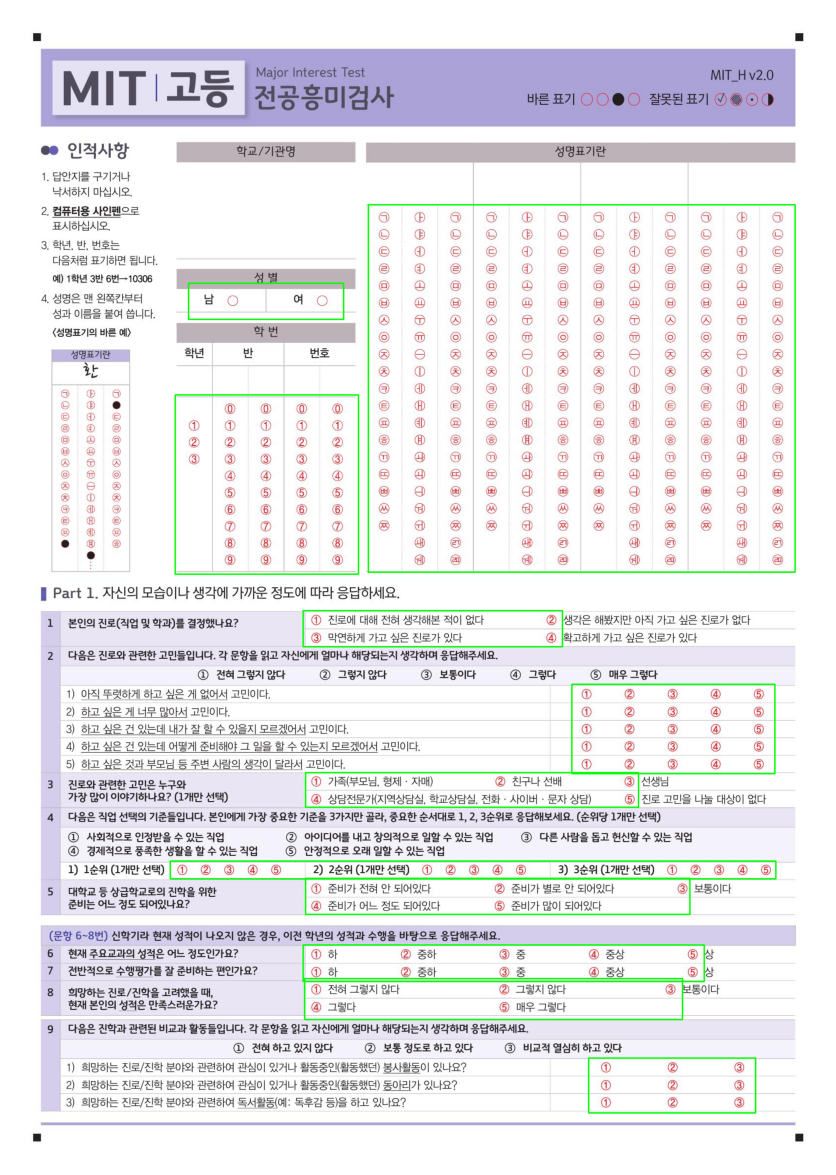

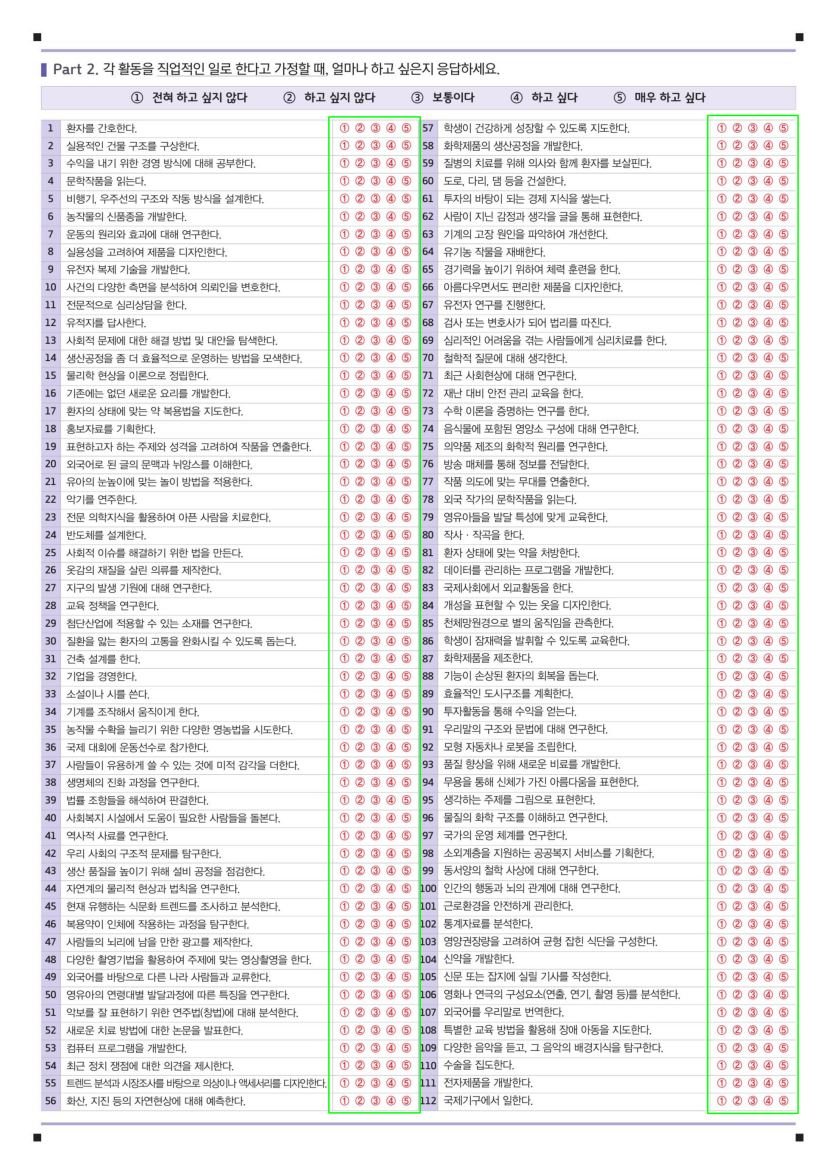

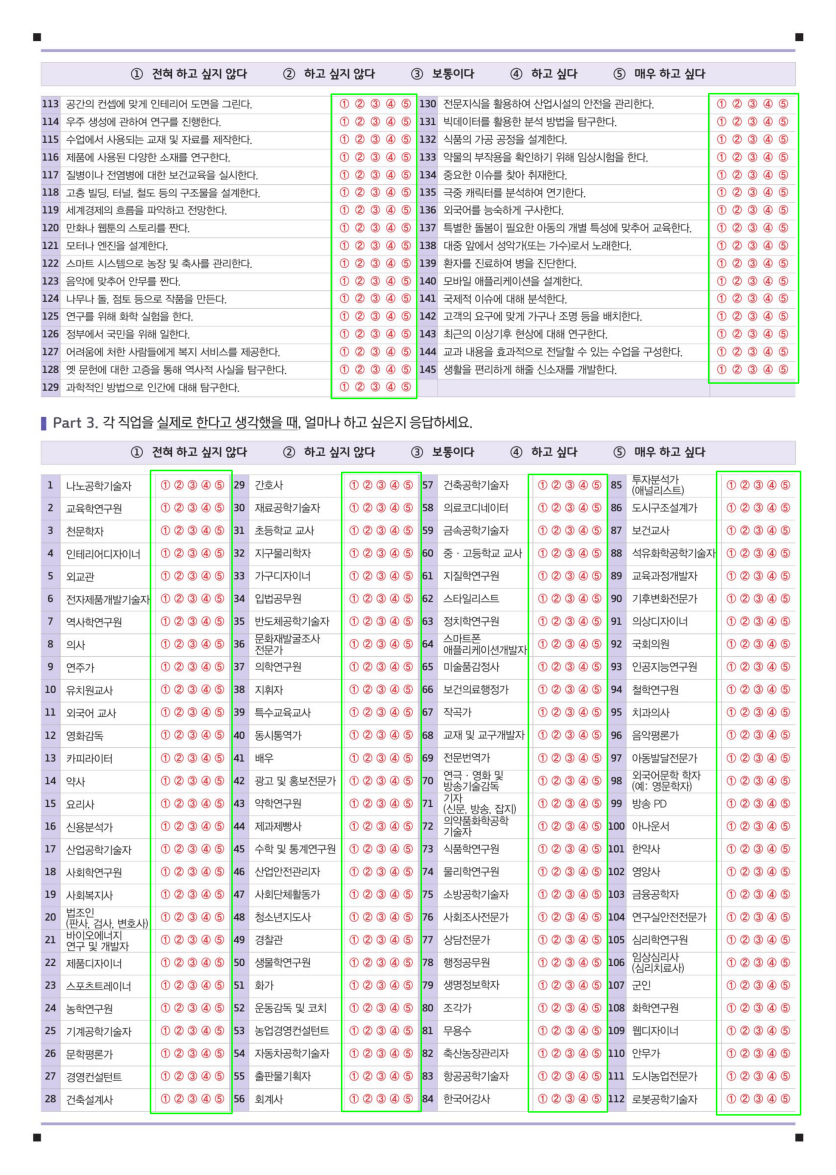

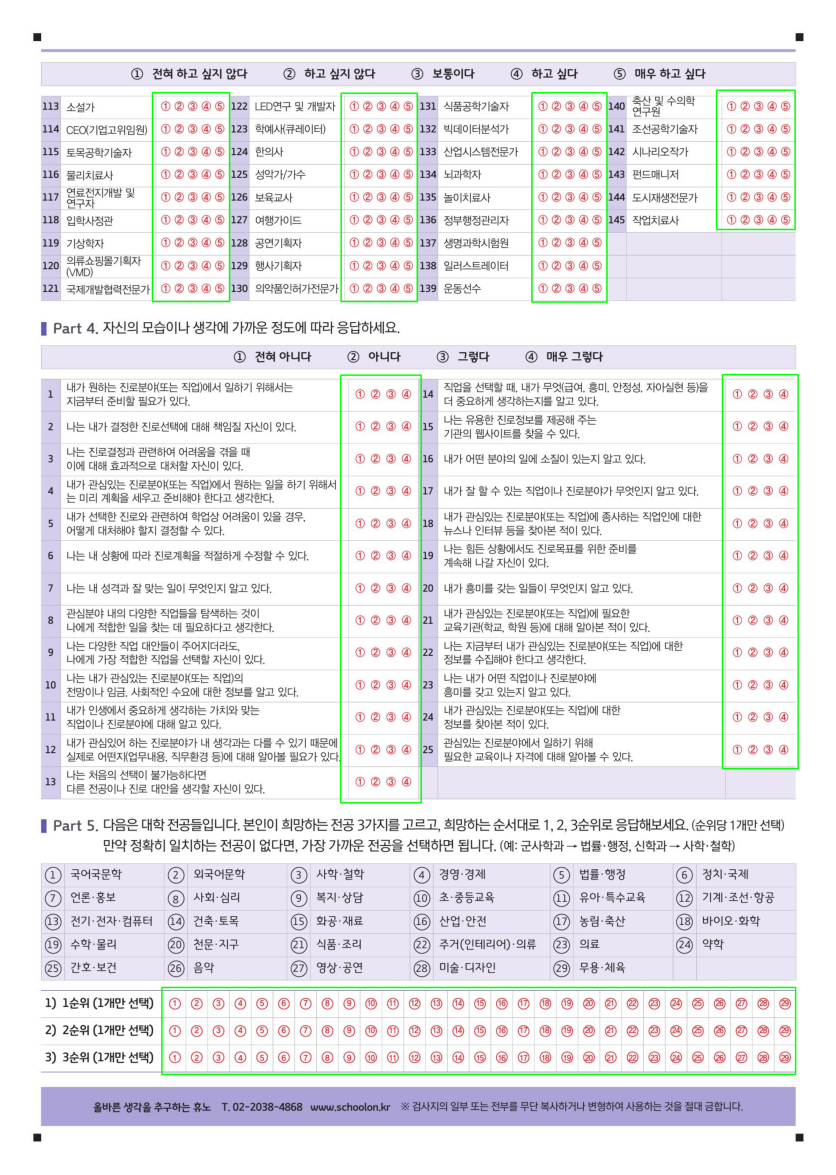

In [1097]:
image_folder = './scan/datas/pdf/divided/tem'
for filename in os.listdir(image_folder):
    if (filename.endswith('.jpg')) and ("_page" not in filename) and ("MIT(고등)" in filename):
        cut_img_dict[filename] = []
        image_path = os.path.join(image_folder, filename)
        img = cv2.imread(image_path)
        num = int(filename.replace(".jpg", "")[-1])
        for x,y,xw,yh,_,_,_,_,_ in asd[num]:
            start_point = (x,y)
            end_point = (xw,yh)
            color = (0, 255, 0)  # 사각형 색상 (B, G, R) 형식
            thickness = 2  # 사각형 선 두께
            cv2.rectangle(img, start_point, end_point, color, thickness)
        plt.figure(figsize=(15, 15))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

In [1098]:
rects_point_dict['MIT(고등)']

{1: [[315, 507, 629, 580, [0], 'A', ['남'], 'gender', [0, 0]],
  [288, 733, 659, 1096, [4], 'A', [1, '.', 0, 0, '.', 0, 0], 'sch', [0, 0]],
  [679, 348, 1543, 1092, [3], 'A', [], 'name', [0, 0]],
  [547, 1170, 1072, 1243, [5, 4], 'part1', [1], '', [0, 0]],
  [1091, 1319, 1502, 1500, [0], 'part1', [1], '', [1, 5]],
  [552, 1498, 1226, 1568, [5, 5], 'part1', [1], '', [0, 0]],
  [278, 1677, 1504, 1713, [0, 5, 5, 5], 'part1', [1, 1, 1], '', [1, 3]],
  [552, 1712, 1330, 1785, [5, 5], 'part1', [1], '', [0, 0]],
  [547, 1847, 1359, 1921, [0, 5, 5], 'part1', [1, 1], '', [0, 0]],
  [550, 1915, 1315, 1998, [5, 5], 'part1', [1], '', [0, 0]],
  [1125, 2076, 1463, 2187, [0], 'part1', [1], '', [1, 3]]],
 2: [[599, 170, 784, 2187, [0], 'part2', [1], '', [0, 0]],
  [1366, 167, 1549, 2188, [0], 'part2', [1], '', [0, 0]]],
 3: [[604, 124, 777, 740, [0], 'part2', [1], '', [0, 0]],
  [1368, 123, 1550, 709, [0], 'part2', [1], '', [0, 0]],
  [238, 886, 403, 2188, [0], 'part3', [1], '', [0, 0]],
  [625, 890, 

In [1099]:
#### 최신버전2
def is_in_sector(cnt, project_name, page, circle_point_dict):
    x, y, radius = cnt
    page = int(page)
    
    circle_left = x - radius
    circle_top = y - radius
    circle_right = x + radius
    circle_bottom = y + radius
    
    # 원이 사각형 내부에 완전히 포함되는지 확인
    pass_point = False
    for rdx, rect_point in enumerate(rects_point_dict[project_name][page]):
        sector = rdx+1
        left, top, right, bottom, t, part, start, item, repeat = rect_point
        # if isinstance(t,list):
        #     t = 2
        if (circle_left >= left and
            circle_top >= top and
            circle_right <= right and
            circle_bottom <= bottom):
            pass_point = True
            if project_name not in circle_point_dict:
                circle_point_dict[project_name] = {}
            if page not in circle_point_dict[project_name]:
                circle_point_dict[project_name][page] = {}
            if sector not in circle_point_dict[project_name][page]:
                circle_point_dict[project_name][page][sector] = []

            circle_point_dict[project_name][page][sector].append([int(x), int(y), int(radius), t, part, start, item, repeat])
            break
        
    if not pass_point:
        return False
    
    return True
    

def draw_contours(image_folder, output_folder): # 여기는 문제 없음
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    circle_point_dict = dict()
    for filename in os.listdir(image_folder):
        if (filename.endswith('.jpg')) and ("_page" not in filename):
            if ("CLS_검사지(중고등)" not in filename) and ("FIT" not in filename) and ("MIT" not in filename):
            # if ("MIT(고등)" not in filename):
            # if ("FIT" not in filename):
                continue
            print(filename)
            project_name_page = filename.replace('.jpg', '')
            splited_project_name_page = project_name_page.split('_')
            project_name = "_".join(splited_project_name_page[:-1])
            page = splited_project_name_page[-1]
            
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # 가우시안 블러로 노이즈 감소
            gray = cv2.GaussianBlur(gray, (9, 9), 0)

            # HoughCircles 함수를 사용하여 원 검출
            if ("CLS_검사지(중고등)" in filename) or ("FIT" in filename):
                all_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.0, minDist=20,
                                        param1=50, param2=20, minRadius=9, maxRadius=12)
            
            if ("MIT" in filename):
                all_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.0, minDist=20,
                                        param1=50, param2=25, minRadius=8, maxRadius=13)
            # all_circles = all_circles.astype(int)
            # circles = [(x,y,10) for cnt_list in all_circles for (x,y,r) in cnt_list if is_in_sector((x,y,r), project_name, page, circle_point_dict)]
            if all_circles is not None:
                all_circles = np.round(all_circles[0, :]).astype("int")
                circles = [(x, y, 10) for x, y, r in all_circles if is_in_sector((x, y, r), project_name, page, circle_point_dict)]
            # print(rects_point_dict[project_name][int(page)])
            for x,y,xw,yh,t,part,start,item,repeat in rects_point_dict[project_name][int(page)]:
                start_point = (x,y)
                end_point = (xw,yh)
                color = (0, 255, 0)
                thickness = 2
                cv2.rectangle(image, start_point, end_point, color, thickness)
                
            # 원이 검출되었는지 확인
            # print(filename)
            # print(len(circles))
            if circles is not None:
                for (x, y, r) in circles:
                    cv2.circle(image, (x, y), r, (255, 0, 0), 2)
                    # # 중심점 그리기
                    # cv2.circle(image, (x, y), 2, (0, 0, 255), 3)

            # 결과 이미지 저장
            # result_image_path = os.path.join(output_folder, f"circles_{filename}")
            result_image_path = os.path.join(output_folder, f"{filename}")
            cv2.imwrite(result_image_path, image)
            # plt.figure(figsize=(20, 20))
            # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()
    return circle_point_dict

image_output_folder = './scan/datas/pdf/square/tem' 
contour_output_folder = './scan/datas/pdf/circles/tem'  # 동그라미 검출 이미지를 저장할 폴더 경로

# 이미지에서 윤곽선 검출 및 그리기
circle_point_dict = draw_contours(image_output_folder, contour_output_folder)
circle_point_dict = {k: v for k, v in sorted(circle_point_dict.items())}
circle_point_dict = {k: {sk: sv for sk, sv in sorted(v.items())} for k, v in circle_point_dict.items()}
circle_point_dict = {k: {sk: {ssk: ssv for ssk, ssv in sorted(sv.items())} for sk, sv in v.items()} for k, v in circle_point_dict.items()}

CLS_검사지(중고등)_1.jpg
CLS_검사지(중고등)_2.jpg
CLS_검사지(중고등)_3.jpg
CLS_검사지(중고등)_4.jpg
FIT_1.jpg
FIT_2.jpg
FIT_3.jpg
FIT_4.jpg
MIT(고등)_1.jpg
MIT(고등)_2.jpg
MIT(고등)_3.jpg
MIT(고등)_4.jpg


In [1100]:
circle_point_dict.keys()

dict_keys(['CLS_검사지(중고등)', 'FIT', 'MIT(고등)'])

In [1101]:
#### 최신
# def make_question_and_choice(c_df, type_):
def make_question_and_choice(s_df, type_name_dict, eng_list):
    
    type_list = s_df['type'].values[0]
    start_list = s_df['start'].values[0]
    type_, select_cnt = type_list[0], type_list[1:]
    
    if type_ == 0:              # 가로형
        sort_col = 'y'
        sort_row = 'x'
    if type_ in [1,3,4]:              # 세로형 이름형 숫자결합형
        sort_col = 'x'
        sort_row = 'y'
        if type_ == 4:
            origin_start_list = start_list[:]
            start_list = [i for i in start_list if isinstance(i, int)]
    if type_ == 5: # 가로-혼합형
        sort_col = 'y'
        sort_row = 'x'
    if type_ == 6: # 세로-혼합형
        sort_col = 'x'
        sort_row = 'y'

        
    c_df = s_df.sort_values(by=sort_col)
    col_current = c_df[sort_col].values[0]
    col_question_num_list = []
    col_chk_equal_question_num = [1]
    col_list = c_df[sort_col][1:]
    
    q_c_df = pd.DataFrame()
    for cdx, col in enumerate(col_list):
        if (abs(col_current - col) > 20) or (cdx == len(col_list)-1):
            col_question_num_list += col_chk_equal_question_num
            col_chk_equal_question_num = [col_chk_equal_question_num[-1]+1]
        else:
            col_chk_equal_question_num += [col_chk_equal_question_num[0]]
        col_current = col
    c_df['question_num'] = col_question_num_list + [col_question_num_list[-1]]
    
    for ddx, small_df in c_df.groupby(['page', 'sector', 'question_num']):
        small_df = small_df.sort_values(sort_row).reset_index(drop=True)
        small_df['choices_count'] = [i+1 for i in range(len(small_df))]
        q_c_df = pd.concat([q_c_df, small_df], axis=0)
    # display(q_c_df)

    if type_ not in [3,4]:
        if len(select_cnt) >= 1:
            q_list, c_list = [], []
            max_q_num = [i for i in range(1, len(select_cnt)+1)]
            for i, j in zip(max_q_num, select_cnt):
                for j_j in range(j):
                    q_list.append(i)
                    c_list.append(j_j+1)
            q_c_df['question_num'] = q_list
            q_c_df['choices_count'] = c_list
    q_c_df['type'] = type_
    
    if type_ == 4:
        detail_num_type_item_list = []
        ndx = 1
        for i in origin_start_list:
            if not isinstance(i,int):
                ndx +=1
                continue
            detail_num_type_item_list += [ndx]
        q_c_df['item'] += q_c_df['question_num'].apply(lambda x : f"{detail_num_type_item_list[x-1]}")   
                     
    q_c_df['real_num'] = 0
    real_num_list = []
    start_schl_list = ['초', '중', '고', '대']
    start_gender_list = ['남', '여']
    for qdx, small_df in q_c_df.groupby(['page', 'sector', 'question_num']):
        if len(start_list) == 0: # 이름형
            real_num_list = q_c_df.apply(
                lambda x: type_name_dict[x['question_num']%3][x['choices_count']],
                axis=1)
            q_c_df['real_num'] = real_num_list
            continue
        elif len(start_list) > 1:
            st_value = start_list[qdx[-1]-1]
        else:
            st_value = start_list[0]
            
        if isinstance(st_value, str):
            if st_value in eng_list:
                st_eng_index = eng_list.index(st_value)
                real_num_list += eng_list[st_eng_index:len(small_df)]
            
            for start_schl in start_schl_list:
                if start_schl in st_value:
                    st_schl_index = start_schl_list.index(start_schl)
                    real_num_list += start_schl_list[st_schl_index:len(small_df)+1]
            
            for sdx, start_gender in enumerate(start_gender_list):
                if start_gender in st_value:
                    if sdx == 0:
                        real_num_list += start_gender_list
                    else:
                        real_num_list += start_gender_list[::-1]
                        
        else:
            real_num_list += [i + st_value for i in range(len(small_df))]
    q_c_df['real_num'] = real_num_list    
    # q_c_df['item'] = item
    # display(q_c_df)
    return q_c_df

type_name_dict = dict()
type_name_dict[1] = {idx+1: i for idx, i in enumerate(['ㄱ','ㄴ','ㄷ','ㄹ','ㅁ','ㅂ','ㅅ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ','ㄲ','ㄸ','ㅃ','ㅆ','ㅉ'])}
type_name_dict[2] = {idx+1: i for idx, i in enumerate(['ㅏ','ㅑ','ㅓ','ㅕ','ㅗ','ㅛ','ㅜ','ㅠ','ㅡ','ㅣ','ㅔ','ㅐ','ㅖ','ㅒ','ㅘ','ㅚ','ㅢ','ㅝ','ㅟ','ㅙ','ㅞ'])}
type_name_dict[0] = {idx+1: i for idx, i in enumerate(['ㄱ','ㄴ','ㄷ','ㄹ','ㅁ','ㅂ','ㅅ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ','ㄲ','ㄸ','ㅃ','ㅆ','ㅉ','ㄺ','ㄻ'])}

# eng_dict = {idx+1 : chr(i) for idx, i in enumerate(range(ord("A"), ord("Z")+1))}
eng_list = [chr(i) for idx, i in enumerate(range(ord("A"), ord("Z")+1))]

project_dict = dict()
for project_name, pages_dict in circle_point_dict.items():
    if ("CLS_검사지(중고등)" not in project_name) and ("FIT" not in project_name) and ("MIT" not in project_name):
        continue
    print(project_name)
    project_df = pd.DataFrame()
    for page, sector_dict in pages_dict.items():
        page_df = pd.DataFrame()
        for sector, circle_list in sector_dict.items():
            df = pd.DataFrame(circle_list, columns=['x', 'y', 'r', 'type', 'part', 'start', 'item', 'repeat'])
            df['page'] = page
            df['sector'] = sector
            df = df[['x', 'y', 'r', 'page', 'sector', 'type', 'part', 'start', 'item', 'repeat']]
            page_df = pd.concat([page_df, df], axis = 0).reset_index(drop=True)
        project_df = pd.concat([project_df, page_df], axis = 0).reset_index(drop=True)
        
    question_and_choice_df = pd.DataFrame()
    for idx, small_df in project_df.groupby(['page', 'sector']):
        grouped_question_and_choice_df = make_question_and_choice(small_df, type_name_dict, eng_list)
        question_and_choice_df = pd.concat([question_and_choice_df, grouped_question_and_choice_df], axis = 0).reset_index(drop = True)
        
    question_and_choice_df = question_and_choice_df.reset_index(drop = True)
    json_df = question_and_choice_df.to_json(orient='columns')
    project_dict[project_name] = json.loads(json_df)  

CLS_검사지(중고등)
FIT
MIT(고등)


In [1102]:
print(rects_point_dict.keys())
print(circle_point_dict.keys())
print(project_dict.keys())

dict_keys(['MIT(고등)', 'CLS_검사지(중고등)', 'FIT'])
dict_keys(['CLS_검사지(중고등)', 'FIT', 'MIT(고등)'])
dict_keys(['CLS_검사지(중고등)', 'FIT', 'MIT(고등)'])


In [1103]:
# with open('./scan/datas/json/rects_point_dict.json', 'w') as f:
#     json.dump(rects_point_dict, f, ensure_ascii=False, indent=4)
    
# with open('./scan/datas/json/circle_point_dict.json', 'w') as f:
#     json.dump(circle_point_dict, f, ensure_ascii=False, indent=4)
    
# with open('./scan/datas/json/project_dict.json', 'w') as f:
#     json.dump(project_dict, f, ensure_ascii=False, indent=4)

---

In [1078]:
df = pd.DataFrame(project_dict['CLS_검사지(중고등)'])

In [1086]:
p = 1
s = 7

tmpdf = df.loc[(df['page'] == p) & (df['sector'] == s)]
print(len(tmpdf))
print(tmpdf['question_num'].max())
print(tmpdf['real_num'].unique())
df.loc[(df['page'] == p) & (df['sector'] == s)]

23
4
[1 2 3 4 5 6 7]


x     y   r  page  sector  type     part         start item  repeat  \
356   790  1766  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
357   904  1764  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
358   790  1824  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
359   904  1824  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
360  1018  1824  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
361   788  1868  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
362   904  1868  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
363  1018  1868  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
364  1190  1868  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
365   790  1942  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
366   904  1940  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
367  1018  1940  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
368   790  1984  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
369   904  1984  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
370  1018  1984  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
371  1190  1984  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
372   788  2074  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
373   904  2074  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
374  1018  2074  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
375   788  2118  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
376   904  2118  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
377  1018  2118  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   
378  1192  2118  10     1       7     0  part1-3  [1, 1, 1, 1]       [0, 0]   

     question_num  choices_count real_num  
356             1              1        1  
357             1              2        2  
358             2              1        1  
359             2              2        2  
360             2              3        3  
361             2              4        4  
362             2              5        5  
363             2              6        6  
364             2              7        7  
365             3              1        1  
366             3              2        2  
367             3              3        3  
368             3              4        4  
369             3              5        5  
370             3              6        6  
371             3              7        7  
372             4              1        1  
373             4              2        2  
374             4              3        3  
375             4              4        4  
376             4              5        5  
377             4              6        6  
378             4              7        7

---

In [1032]:
df_4 = df.loc[df['type'] == 4]
df_4

x     y   r  page  sector  type part            start item  repeat  \
4   308   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
5   308   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
6   308   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
7   380   778  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
8   380   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
9   380   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
10  382   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
11  380   914  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
12  382   948  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
13  380   982  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
14  382  1016  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
15  382  1050  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
16  380  1084  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
17  454   778  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
18  454   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
19  454   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
20  454   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
21  454   914  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
22  454   948  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
23  454   982  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
24  454  1016  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
25  454  1050  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
26  454  1084  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
27  528   778  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
28  528   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
29  528   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
30  528   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
31  528   914  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
32  528   948  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
33  528   982  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
34  528  1016  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
35  528  1050  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
36  528  1084  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
37  602   778  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
38  602   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
39  602   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
40  602   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
41  602   914  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
42  602   948  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
43  602   982  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
44  602  1016  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
45  602  1050  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
46  602  1084  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   

    question_num  choices_count real_num  
4              1              1        1  
5              1              2        2  
6              1              3        3  
7              2              1        0  
8              2              2        1  
9              2              3        2  
10             2              4        3  
11             2              5        4  
12             2              6        5  
13             2              7        6  
14             2              8        7  
15             2              9        8  
16             2             10        9  
17             3              1        0  
18             3

In [1033]:
df_4

x     y   r  page  sector  type part            start item  repeat  \
4   308   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
5   308   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
6   308   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
7   380   778  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
8   380   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
9   380   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
10  382   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
11  380   914  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
12  382   948  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
13  380   982  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
14  382  1016  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
15  382  1050  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
16  380  1084  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
17  454   778  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
18  454   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
19  454   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
20  454   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
21  454   914  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
22  454   948  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
23  454   982  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
24  454  1016  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
25  454  1050  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
26  454  1084  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
27  528   778  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
28  528   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
29  528   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
30  528   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
31  528   914  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
32  528   948  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
33  528   982  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
34  528  1016  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
35  528  1050  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
36  528  1084  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
37  602   778  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
38  602   812  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
39  602   846  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
40  602   880  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
41  602   914  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
42  602   948  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
43  602   982  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
44  602  1016  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
45  602  1050  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   
46  602  1084  11     1       3     4    A  [1, 0, 0, 0, 0]  sch  [0, 0]   

    question_num  choices_count real_num  
4              1              1        1  
5              1              2        2  
6              1              3        3  
7              2              1        0  
8              2              2        1  
9              2              3        2  
10             2              4        3  
11             2              5        4  
12             2              6        5  
13             2              7        6  
14             2              8        7  
15             2              9        8  
16             2             10        9  
17             3              1        0  
18             3

In [1065]:
[i for i in a if isinstance(i, int)]

[1, 0, 0, 0, 0]

In [1063]:
classification_method = "1.00.00"
a = [int(i) if i.isdigit() else i for i in classification_method]
a

[1, '.', 0, 0, '.', 0, 0]

In [1038]:
detail_num_type_item_list = []
ndx = 1
for i in a:
    if not isinstance(i,int):
        ndx +=1
        continue
    detail_num_type_item_list += [ndx]
        
detail_num_type_item_list

[1, 2, 2, 3, 3]

In [1045]:
df_4['item'] + df_4['question_num'].apply(lambda x : f"_{detail_num_type_item_list[x-1]}")

4     sch_1
5     sch_1
6     sch_1
7     sch_2
8     sch_2
9     sch_2
10    sch_2
11    sch_2
12    sch_2
13    sch_2
14    sch_2
15    sch_2
16    sch_2
17    sch_2
18    sch_2
19    sch_2
20    sch_2
21    sch_2
22    sch_2
23    sch_2
24    sch_2
25    sch_2
26    sch_2
27    sch_3
28    sch_3
29    sch_3
30    sch_3
31    sch_3
32    sch_3
33    sch_3
34    sch_3
35    sch_3
36    sch_3
37    sch_3
38    sch_3
39    sch_3
40    sch_3
41    sch_3
42    sch_3
43    sch_3
44    sch_3
45    sch_3
46    sch_3
dtype: object